In [109]:

!pip install -q ultralytics pycocotools opencv-python matplotlib

import os, shutil, json
from pathlib import Path
from pycocotools.coco import COCO
import matplotlib.pyplot as plt
import cv2
from ultralytics import YOLO


In [111]:
DATASET_DIR = Path("D:/Airfusion/SkyFusion") 
SPLITS = ["train", "valid", "test"]           
COCO_FILENAMES = {
    "train": "train/_annotations.coco.json",
    "valid": "valid/_annotations.coco.json",
    "test":  "test/_annotations.coco.json"
}

PRETRAINED = "yolov8s.pt"   
EPOCHS = 50
IMGSZ = 640
BATCH = 8   


In [113]:
# Ensure structure: split/images and split/labels. Move image files into images/ if they were in split root.
IMG_EXTS = {".jpg", ".jpeg", ".png", ".bmp", ".tif", ".tiff"}

def ensure_split_structure(split):
    split_dir = DATASET_DIR / split
    images_dir = split_dir / "images"
    labels_dir = split_dir / "labels"
    images_dir.mkdir(parents=True, exist_ok=True)
    labels_dir.mkdir(parents=True, exist_ok=True)
    # move any image files sitting directly in split_dir into images_dir
    for f in split_dir.iterdir():
        if f.is_file() and f.suffix.lower() in IMG_EXTS and f.parent == split_dir:
            shutil.move(str(f), str(images_dir / f.name))
    return images_dir, labels_dir

for s in SPLITS:
    imgs, lbls = ensure_split_structure(s)
    print(f"{s}: images -> {imgs}, labels -> {lbls}, image_count = {len(list(imgs.glob('*'))) }")


train: images -> D:\Airfusion\SkyFusion\train\images, labels -> D:\Airfusion\SkyFusion\train\labels, image_count = 2094
valid: images -> D:\Airfusion\SkyFusion\valid\images, labels -> D:\Airfusion\SkyFusion\valid\labels, image_count = 449
test: images -> D:\Airfusion\SkyFusion\test\images, labels -> D:\Airfusion\SkyFusion\test\labels, image_count = 449


In [115]:
# COCO to YOLO conversion
def coco_to_yolo(coco_json_path, images_dir, labels_dir, wanted_classes=None):
    """
    coco_json_path: path to annotations file
    images_dir: folder with images (Path object)
    labels_dir: folder to write YOLO txts (Path object)
    wanted_classes: None (use all classes in JSON) or list of names to keep
    Returns: list of class names used (ordered)
    """
    coco = COCO(str(coco_json_path))
    cats = coco.loadCats(coco.getCatIds())
    # Build mapping: COCO category_id -> consecutive index 0..N-1
    if wanted_classes:
        wanted = set(wanted_classes)
        filtered_cats = [c for c in cats if c["name"] in wanted]
    else:
        filtered_cats = cats
    # Sort by id for determinism
    filtered_cats = sorted(filtered_cats, key=lambda x: x["id"])
    cat_id_to_yolo = {}
    names = []
    for new_idx, cat in enumerate(filtered_cats):
        cat_id_to_yolo[cat["id"]] = new_idx
        names.append(cat["name"])

    # Clear existing label files (optional)
    for fp in Path(labels_dir).glob("*.txt"):
        try:
            fp.unlink()
        except:
            pass

    img_ids = coco.getImgIds()
    written = 0
    for img_id in img_ids:
        info = coco.loadImgs(img_id)[0]
        file_name = info["file_name"]
        img_path = Path(images_dir) / file_name
        if not img_path.exists():
            # skip images that don't exist in images_dir
            continue
        ann_ids = coco.getAnnIds(imgIds=img_id)
        anns = coco.loadAnns(ann_ids)
        # write labels
        lines = []
        for ann in anns:
            cid = ann["category_id"]
            if cid not in cat_id_to_yolo:
                continue  # skip other categories
            # COCO bbox = [x_min, y_min, width, height]
            x, y, w, h = ann["bbox"]
            x_c = (x + w/2) / info["width"]
            y_c = (y + h/2) / info["height"]
            w_n = w / info["width"]
            h_n = h / info["height"]
            cls = cat_id_to_yolo[cid]
            # clamp to (0,1)
            def clamp(v): return max(0.0, min(1.0, float(v)))
            lines.append(f"{cls} {clamp(x_c):.6f} {clamp(y_c):.6f} {clamp(w_n):.6f} {clamp(h_n):.6f}")
        if lines:
            label_path = Path(labels_dir) / (Path(file_name).stem + ".txt")
            label_path.write_text("\n".join(lines))
            written += 1

    print(f"Converted {written} images from {coco_json_path} into {labels_dir}")
    return names

# Run conversion for splits if coco file exists
all_names = None
for split in SPLITS:
    coco_path = DATASET_DIR / COCO_FILENAMES[split]
    images_dir, labels_dir = ensure_split_structure(split)
    if coco_path.exists():
        names = coco_to_yolo(coco_path, images_dir, labels_dir, wanted_classes=None)
        # set all_names once (use train's names if available)
        if split == "train":
            all_names = names
    else:
        print(f"[WARN] COCO annotation not found for {split}: {coco_path}")

if all_names is None:
    # try to read names from any available JSON
    for split in SPLITS:
        coco_path = DATASET_DIR / COCO_FILENAMES[split]
        if coco_path.exists():
            all_names = coco_to_yolo(coco_path, DATASET_DIR / split / "images", DATASET_DIR / split / "labels", wanted_classes=None)
            break
print("Final class names:", all_names)


loading annotations into memory...
Done (t=0.49s)
creating index...
index created!
Converted 2094 images from D:\Airfusion\SkyFusion\train\_annotations.coco.json into D:\Airfusion\SkyFusion\train\labels
loading annotations into memory...
Done (t=0.13s)
creating index...
index created!
Converted 449 images from D:\Airfusion\SkyFusion\valid\_annotations.coco.json into D:\Airfusion\SkyFusion\valid\labels
loading annotations into memory...
Done (t=0.18s)
creating index...
index created!
Converted 449 images from D:\Airfusion\SkyFusion\test\_annotations.coco.json into D:\Airfusion\SkyFusion\test\labels
Final class names: ['Aircraft', 'ship', 'vehicle']


In [117]:
# Create a YOLOv8 data.yaml (uses 'val' key — that's required)
data_yaml_path = DATASET_DIR / "data.yaml"

val_folder_name = "val" if (DATASET_DIR / "val").exists() else "valid" if (DATASET_DIR / "valid").exists() else "valid"

content_lines = [
    f"path: {str(DATASET_DIR).replace(os.sep, '/')}",
    f"train: train/images",
    f"val: {val_folder_name}/images",
    f"test: test/images",
    "",
    f"nc: {len(all_names)}",
    f"names: {all_names}"
]
data_yaml_path.write_text("\n".join(content_lines))
print("[INFO] data.yaml written to", data_yaml_path)
print(data_yaml_path.read_text())


[INFO] data.yaml written to D:\Airfusion\SkyFusion\data.yaml
path: D:/Airfusion/SkyFusion
train: train/images
val: valid/images
test: test/images

nc: 3
names: ['Aircraft', 'ship', 'vehicle']


train: images=2094, labels=2094
valid: images=449, labels=449
test: images=449, labels=449


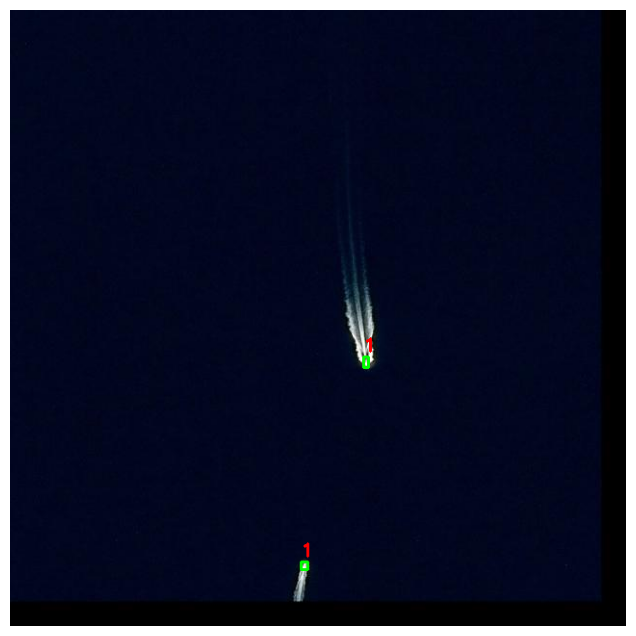

In [119]:
# Check counts and visualize a sample label overlay
def count_images_labels():
    for s in SPLITS:
        images_dir = DATASET_DIR / s / "images"
        labels_dir = DATASET_DIR / s / "labels"
        nimg = len(list(images_dir.glob("*"))) if images_dir.exists() else 0
        nlab = len(list(labels_dir.glob("*.txt"))) if labels_dir.exists() else 0
        print(f"{s}: images={nimg}, labels={nlab}")

count_images_labels()

# visualize first sample from val (or train if val empty)
import random
vis_split = "val" if (DATASET_DIR / "val" / "images").exists() and len(list((DATASET_DIR/"val"/"images").glob("*")))>0 else "train"
imgs = list((DATASET_DIR / vis_split / "images").glob("*"))
if imgs:
    sample = imgs[0]
    img = cv2.cvtColor(cv2.imread(str(sample)), cv2.COLOR_BGR2RGB)
    h, w, _ = img.shape
    label_file = (DATASET_DIR / vis_split / "labels" / (sample.stem + ".txt"))
    if label_file.exists():
        for line in label_file.read_text().strip().splitlines():
            cls, xc, yc, bw, bh = map(float, line.split())
            x1 = int((xc - bw/2) * w); y1 = int((yc - bh/2) * h)
            x2 = int((xc + bw/2) * w); y2 = int((yc + bh/2) * h)
            cv2.rectangle(img, (x1,y1), (x2,y2), (0,255,0), 2)
            cv2.putText(img, str(int(cls)), (x1,y1-6), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255,0,0), 2)
    plt.figure(figsize=(8,8)); plt.imshow(img); plt.axis("off")
else:
    print("No images found to visualize.")


In [121]:
# Train (warning: CPU training is slow; GPU recommended)
model = YOLO(PRETRAINED)  # yolov8n.pt / yolov8s.pt / yolov8m.pt

print("Starting training — will save to 'runs' or project folder by default")
model.train(
    data=str(data_yaml_path),
    epochs=EPOCHS,
    imgsz=IMGSZ,
    batch=BATCH,
    project="yolo_traffic",
    name="exp1",
    exist_ok=True
)

Starting training — will save to 'runs' or project folder by default
New https://pypi.org/project/ultralytics/8.3.203 available  Update with 'pip install -U ultralytics'
Ultralytics YOLOv8.2.83  Python-3.12.7 torch-2.5.0+cpu CPU (11th Gen Intel Core(TM) i5-1135G7 2.40GHz)
engine\trainer: task=detect, mode=train, model=yolov8s.pt, data=D:\Airfusion\SkyFusion\data.yaml, epochs=50, time=None, patience=100, batch=8, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=yolo_traffic, name=exp1, exist_ok=True, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augm

C:\Users\yoges\AppData\Roaming\Python\Python312\site-packages\ultralytics\engine\trainer.py:268: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = torch.cuda.amp.GradScaler(enabled=self.amp)
train: Scanning D:\Airfusion\SkyFusion\train\labels... 2094 images, 0 backgrounds, 0 corrupt: 100%|██████████| 2094/209


train: New cache created: D:\Airfusion\SkyFusion\train\labels.cache


val: Scanning D:\Airfusion\SkyFusion\valid\labels... 449 images, 0 backgrounds, 0 corrupt: 100%|██████████| 449/449 [00

val: New cache created: D:\Airfusion\SkyFusion\valid\labels.cache


Plotting labels to yolo_traffic\exp1\labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001429, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
TensorBoard: model graph visualization added 
Image sizes 640 train, 640 val
Using 0 dataloader workers
Logging results to yolo_traffic\exp1
Starting training for 50 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/50         0G      1.855      1.578      1.118         34        640: 100%|██████████| 262/262 [1:09:22<00:00,
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [06:42

                   all        449       8387      0.475      0.431      0.387      0.221



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/50         0G      1.785      1.139       1.06        166        640: 100%|██████████| 262/262 [44:32<00:00, 1
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [03:20

                   all        449       8387      0.469      0.419      0.386      0.229



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/50         0G      1.804      1.116      1.055        309        640: 100%|██████████| 262/262 [41:55<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [03:19

                   all        449       8387      0.535      0.441      0.411      0.225



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/50         0G      1.727      1.098      1.056        155        640: 100%|██████████| 262/262 [41:30<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [03:16

                   all        449       8387      0.512      0.482       0.44      0.239



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/50         0G      1.691     0.9981      1.029        101        640: 100%|██████████| 262/262 [41:23<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [03:18

                   all        449       8387      0.506      0.485      0.438      0.249



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/50         0G      1.643     0.9613      1.015         46        640: 100%|██████████| 262/262 [40:20<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [03:16

                   all        449       8387       0.57      0.498       0.48      0.257



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/50         0G      1.642     0.9521      1.011        203        640: 100%|██████████| 262/262 [40:40<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [03:18

                   all        449       8387      0.537      0.522      0.485      0.254



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/50         0G        1.6     0.9059      1.009         36        640: 100%|██████████| 262/262 [40:06<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [03:12

                   all        449       8387      0.554      0.513      0.483      0.265



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/50         0G        1.6      0.906      1.005         54        640: 100%|██████████| 262/262 [3:52:24<00:00,
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [03:08

                   all        449       8387      0.532      0.483      0.455      0.252



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/50         0G      1.612     0.9041     0.9944         48        640: 100%|██████████| 262/262 [38:25<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [03:08

                   all        449       8387      0.573      0.533      0.512      0.282



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/50         0G      1.601     0.8828     0.9965        163        640: 100%|██████████| 262/262 [42:38<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [03:17

                   all        449       8387      0.565        0.5      0.481      0.265



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/50         0G      1.593     0.8561     0.9866         53        640: 100%|██████████| 262/262 [42:54<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [03:19

                   all        449       8387      0.606      0.546      0.539      0.289



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/50         0G      1.556      0.856      0.983         66        640: 100%|██████████| 262/262 [43:34<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [03:07

                   all        449       8387      0.561      0.557      0.521      0.277



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/50         0G      1.532     0.8121     0.9859         81        640: 100%|██████████| 262/262 [40:11<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [03:04

                   all        449       8387      0.568      0.551      0.526      0.284



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/50         0G      1.533     0.8085     0.9798        350        640:  49%|████▉     | 128/262 [22:29<23:32, 1

KeyboardInterrupt



In [122]:
#  Evaluate
metrics = model.val()   # returns dictionary-like metrics
print(metrics)


Ultralytics YOLOv8.2.83  Python-3.12.7 torch-2.5.0+cpu CPU (11th Gen Intel Core(TM) i5-1135G7 2.40GHz)
Model summary (fused): 168 layers, 11,126,745 parameters, 13,641 gradients, 28.4 GFLOPs

Dataset 'coco.yaml' images not found , missing path 'C:\Users\yoges\datasets\coco\val2017.txt'


100%|████████████████████████████████████████████████████████████████████████████████| 169M/169M [03:29<00:00, 843kB/s]
Unzipping C:\Users\yoges\datasets\coco2017labels-segments.zip to C:\Users\yoges\datasets\coco...: 100%|██████████| 1222


KeyboardInterrupt: 

In [ ]:
# Inference: run on the test folder, save predictions
test_images_dir = DATASET_DIR / "test" / "images"
results = model.predict(source=str(test_images_dir), imgsz=IMGSZ, conf=0.25, save=True)


if results:
    res0 = results[0]
    # plot using ultralytics built-in
    out_img = res0.plot()  # returns BGR numpy array annotated
    out_img = cv2.cvtColor(out_img, cv2.COLOR_BGR2RGB)
    plt.figure(figsize=(10,10)); plt.imshow(out_img); plt.axis("off")
    print("Saved predictions to:", res0.save_dir)
else:
    print("No predictions returned.")
